### Objectif :

#### Ce notebook décris la méthodologie, les algorithmes et les pistes d’améliorations.
- Premièrement j'ai essayer de reduire la taille du problème en appliquant **K_means** sur ma base sans la variable '**Description**' pour avoir mes premiers clusters.
- Ensuite, je me suis ensuite concentré sur la variable "**Description**", j'ai fait un peu de traitement de texte et j'ai calculé le cos similarité (cosine_similarity) entre chaque description et les autres (pairwise_distances). Une fois ce calcul effectué, j'ai construit mes seconds clusters.
- Enfin, j'ai construit une matrice de similarité entre les variables de ma nouvelle base de données, cette fois-ci avec mes nouvelles variables de cluster. <mark>J'ai essayé de décrire plus en détail cette approche à la fin du notebook (**Merci ce la voir**)</mark>.

In [1]:
# imports
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.metrics import pairwise_distances

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import make_column_transformer

from functions import * # function.py file

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# load newest data
DATA_PATH = "../data/new_data.csv"

data = pd.read_csv(DATA_PATH)

Your selected dataframe has 20 columns.



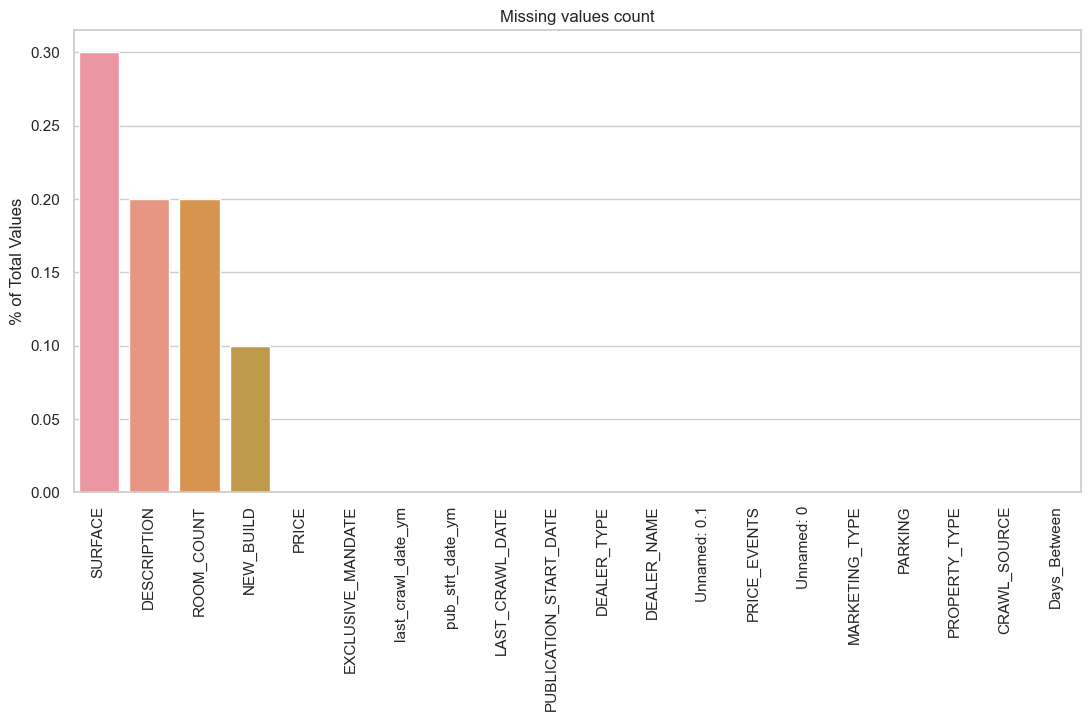

,Missing Values,% of Total Values,Type
SURFACE,7,0.3,float64
DESCRIPTION,4,0.2,str
ROOM_COUNT,4,0.2,float64
NEW_BUILD,3,0.1,str
PRICE,1,0.0,float64
EXCLUSIVE_MANDATE,0,0.0,bool
last_crawl_date_ym,0,0.0,str
pub_strt_date_ym,0,0.0,str
LAST_CRAWL_DATE,0,0.0,str
PUBLICATION_START_DATE,0,0.0,str


In [3]:
missing_values_table(data)

#### Pour cette nouvelle base, qui ne comporte pratiquement pas de valeurs manquantes (0.3% pour la plus grande), j'ai décidé de les supprimer pour cette phase de modélisation.

In [4]:
data.head(2)

,Unnamed: 0.1,Unnamed: 0,CRAWL_SOURCE,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,PRICE_EVENTS,EXCLUSIVE_MANDATE,DEALER_NAME,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,pub_strt_date_ym,last_crawl_date_ym,Days_Between
0,0,0,A_VENDRE_A_LOUER,APARTMENT,False,"Au rez de chaussée d'un bel immeuble récent,ap...",72.0,3.0,True,RENT,1979.0,"[{""price"":1979,""date"":""2017-03-22""}]",False,Lamirand Et Associes,AGENCY,2017-03-22 04:07:56.095,2017-04-21 18:52:35.733,2017-03,2017-04,30
1,1,1,BIEN_ICI,APARTMENT,False,Je vous propose un appartement dans la rue Col...,48.0,2.0,False,SALE,429000.0,"[{""price"":452000.0,""date"":""2018-09-18""},{""pric...",False,Proprietes Privees,MANDATARY,2018-09-18 11:04:44.461,2019-06-06 10:08:10.890,2018-09,2019-06,260


In [5]:
# Colonnes à exploiter ultérieurement
USELESS_COL = [
    "CRAWL_SOURCE",  "DEALER_NAME",
    'pub_strt_date_ym', 'last_crawl_date_ym',
    'Unnamed: 0.1', 'Unnamed: 0',
    "PRICE_EVENTS"
]
data_useful = data.drop(labels=USELESS_COL, axis=1)

In [6]:
data_useful.head()

,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,EXCLUSIVE_MANDATE,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,Days_Between
0,APARTMENT,False,"Au rez de chaussée d'un bel immeuble récent,ap...",72.0,3.0,True,RENT,1979.0,False,AGENCY,2017-03-22 04:07:56.095,2017-04-21 18:52:35.733,30
1,APARTMENT,False,Je vous propose un appartement dans la rue Col...,48.0,2.0,False,SALE,429000.0,False,MANDATARY,2018-09-18 11:04:44.461,2019-06-06 10:08:10.890,260
2,APARTMENT,False,"Dans un cadre arboré, calme et fleuri, un pent...",267.0,6.0,False,SALE,4970000.0,False,AGENCY,2019-02-19 16:49:03.547,2019-06-13 08:22:14.314,113
3,PREMISES,False,"""Le meilleur coworking flexible de la ville, 5...",50.0,0.0,False,RENT,89.0,False,AGENCY,2018-07-06 15:18:59.805,2019-06-18 10:40:07.405,346
4,HOUSE,False,Levallois - Parc de la Planchette A toute prox...,330.0,8.0,False,SALE,2790000.0,False,AGENCY,2019-04-08 17:12:20.123,2019-06-14 15:02:18.155,66


## K-means

#### Tout d'abors je vais commencer par réduire la taille du problème, en essayant de construire nos premières Clusters avec le modèle de K-means.

<mark> **Préparation de la base** </mark>

In [7]:
excluded_column = 'DESCRIPTION'

# Sélectionner toutes les colonnes à l'exception de la colonne Description
k_variables = data_useful.drop(columns=[excluded_column]).columns
k_variables

Index(['PROPERTY_TYPE', 'NEW_BUILD', 'SURFACE', 'ROOM_COUNT', 'PARKING',
       'MARKETING_TYPE', 'PRICE', 'EXCLUSIVE_MANDATE', 'DEALER_TYPE',
       'PUBLICATION_START_DATE', 'LAST_CRAWL_DATE', 'Days_Between'],
      dtype='object')

In [8]:
Kmeans_data = data_useful[k_variables]

In [9]:
# to_ date pour les varibles date

# Kmeans_data['PUBLICATION_START_DATE'] = pd.to_datetime(Kmeans_data['PUBLICATION_START_DATE'])
# Kmeans_data['LAST_CRAWL_DATE'] = pd.to_datetime(Kmeans_data['LAST_CRAWL_DATE'])

In [10]:
Kmeans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PROPERTY_TYPE           2164 non-null   object 
 1   NEW_BUILD               2161 non-null   object 
 2   SURFACE                 2157 non-null   float64
 3   ROOM_COUNT              2160 non-null   float64
 4   PARKING                 2164 non-null   bool   
 5   MARKETING_TYPE          2164 non-null   object 
 6   PRICE                   2163 non-null   float64
 7   EXCLUSIVE_MANDATE       2164 non-null   bool   
 8   DEALER_TYPE             2164 non-null   object 
 9   PUBLICATION_START_DATE  2164 non-null   object 
 10  LAST_CRAWL_DATE         2164 non-null   object 
 11  Days_Between            2164 non-null   int64  
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 173.4+ KB


<mark> **Encoder nos variables catégorielles** </mark>

In [11]:
enc = OrdinalEncoder()
enc.fit(Kmeans_data[["PROPERTY_TYPE"]])
Kmeans_data[["PROPERTY_TYPE"]] = enc.transform(Kmeans_data[["PROPERTY_TYPE"]])

In [12]:
Kmeans_data["EXCLUSIVE_MANDATE"] = Kmeans_data["EXCLUSIVE_MANDATE"].astype(int)
Kmeans_data["PARKING"] = Kmeans_data["PARKING"].astype(int)
Kmeans_data['NEW_BUILD'] = Kmeans_data['NEW_BUILD'].map({'True': 1, 'False': 0, '-1': -1})
Kmeans_data['MARKETING_TYPE'] = Kmeans_data['MARKETING_TYPE'].map({'RENT': 1, 'SALE': 0})

In [13]:
enc.fit(Kmeans_data[["DEALER_TYPE"]])
Kmeans_data[['DEALER_TYPE']] = enc.transform(Kmeans_data[["DEALER_TYPE"]])

In [14]:
Kmeans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PROPERTY_TYPE           2164 non-null   float64
 1   NEW_BUILD               2161 non-null   float64
 2   SURFACE                 2157 non-null   float64
 3   ROOM_COUNT              2160 non-null   float64
 4   PARKING                 2164 non-null   int32  
 5   MARKETING_TYPE          2164 non-null   int64  
 6   PRICE                   2163 non-null   float64
 7   EXCLUSIVE_MANDATE       2164 non-null   int32  
 8   DEALER_TYPE             2164 non-null   float64
 9   PUBLICATION_START_DATE  2164 non-null   object 
 10  LAST_CRAWL_DATE         2164 non-null   object 
 11  Days_Between            2164 non-null   int64  
dtypes: float64(6), int32(2), int64(2), object(2)
memory usage: 186.1+ KB


In [15]:
from datetime import datetime

# Définir la fonction permettant de convertir une chaîne de date et d'heure en un horodatage
def date_time_to_timestamp(date_time_str, reference_date_time_str):
    reference_date_time_obj = datetime.strptime(reference_date_time_str, '%Y-%m-%d %H:%M:%S.%f')
    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')
    time_difference = date_time_obj - reference_date_time_obj
    return time_difference.total_seconds()


# Définir la date et l'heure de référence sous forme de chaîne (en supposant qu'il s'agit de la date minimale de 'PUBLICATION_START_DATE')
reference_date_time_str = '2015-01-01 00:00:50.00' 

# Appliquer la conversion de la date en horodatage à l'ensemble du DataFrame et créer une nouvelle colonne "TIMESTAMP".

Kmeans_data['PUBLICATION_START_TIMESTAMP'] = Kmeans_data['PUBLICATION_START_DATE'].apply(
    lambda date_time_str: date_time_to_timestamp(date_time_str, reference_date_time_str)
)

Kmeans_data['LAST_CRAWL_DATE_TIMESTAMP'] = Kmeans_data['LAST_CRAWL_DATE'].apply(
    lambda date_time_str: date_time_to_timestamp(date_time_str, reference_date_time_str)
)


In [16]:
Kmeans_data = Kmeans_data.drop(columns= ['PUBLICATION_START_DATE', 'LAST_CRAWL_DATE']) # J'ai supp les variables date après avoir exploiter et changer en variables numériques

In [17]:
Kmeans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PROPERTY_TYPE                2164 non-null   float64
 1   NEW_BUILD                    2161 non-null   float64
 2   SURFACE                      2157 non-null   float64
 3   ROOM_COUNT                   2160 non-null   float64
 4   PARKING                      2164 non-null   int32  
 5   MARKETING_TYPE               2164 non-null   int64  
 6   PRICE                        2163 non-null   float64
 7   EXCLUSIVE_MANDATE            2164 non-null   int32  
 8   DEALER_TYPE                  2164 non-null   float64
 9   Days_Between                 2164 non-null   int64  
 10  PUBLICATION_START_TIMESTAMP  2164 non-null   float64
 11  LAST_CRAWL_DATE_TIMESTAMP    2164 non-null   float64
dtypes: float64(8), int32(2), int64(2)
memory usage: 186.1 KB


In [18]:
# Fonction pour supprimer les lignes avec des valeurs manquantes en spécifiant le nom de la colonne 

def drop_rows_with_missing_values(data, columns_to_check):
    
    missing_values = data[columns_to_check].isnull().any(axis=1)

    data_cleaned = data[~missing_values]

    return data_cleaned



In [19]:
Kmeans_data = drop_rows_with_missing_values(Kmeans_data, Kmeans_data.columns)

In [20]:
Kmeans_data.isna().sum()

PROPERTY_TYPE                  0
NEW_BUILD                      0
SURFACE                        0
ROOM_COUNT                     0
PARKING                        0
MARKETING_TYPE                 0
PRICE                          0
EXCLUSIVE_MANDATE              0
DEALER_TYPE                    0
Days_Between                   0
PUBLICATION_START_TIMESTAMP    0
LAST_CRAWL_DATE_TIMESTAMP      0
dtype: int64

#### Elbow Graph 

#### Afin de d'identifier le k optimale pour notre K-means, j'ai utilisé le graph Elbow

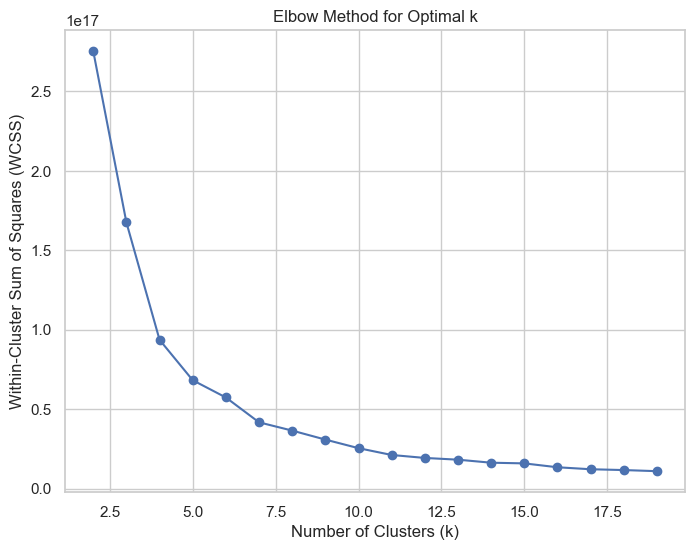

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []


k_range = range(2, 20)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=0)
    kmeans.fit(Kmeans_data)  
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

#### On observe un k moyen de 7

### Entrainement du modèle k-means

In [22]:
k=7
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit(Kmeans_data)  

KMeans(max_iter=100, n_clusters=7, n_init=1, random_state=0)

In [23]:
cluster_labels = kmeans.predict(Kmeans_data)
Kmeans_data['kmeans_cluster'] = cluster_labels

#### Affectation des valeurs de la colonne "**kmeans_cluster**" du DataFrame "**data_useful**"

In [24]:
data_useful.loc[Kmeans_data.index, "kmeans_cluster"] = Kmeans_data['kmeans_cluster']

In [25]:
data_useful['kmeans_cluster'].value_counts()

0.0    1325
4.0     551
2.0     137
3.0      51
5.0      40
1.0      36
6.0      13
Name: kmeans_cluster, dtype: int64

----------------------------------------------------------------------------------------------------------------------

## Exploitation de la variable **'DESCRIPTION'**

In [26]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity



# download nltk corpus (first time only)
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
data_useful.head(3)

,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,EXCLUSIVE_MANDATE,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,Days_Between,kmeans_cluster
0,APARTMENT,False,"Au rez de chaussée d'un bel immeuble récent,ap...",72.0,3.0,True,RENT,1979.0,False,AGENCY,2017-03-22 04:07:56.095,2017-04-21 18:52:35.733,30,1.0
1,APARTMENT,False,Je vous propose un appartement dans la rue Col...,48.0,2.0,False,SALE,429000.0,False,MANDATARY,2018-09-18 11:04:44.461,2019-06-06 10:08:10.890,260,2.0
2,APARTMENT,False,"Dans un cadre arboré, calme et fleuri, un pent...",267.0,6.0,False,SALE,4970000.0,False,AGENCY,2019-02-19 16:49:03.547,2019-06-13 08:22:14.314,113,4.0


In [28]:
data_useful['DESCRIPTION'] = data_useful['DESCRIPTION'].fillna('')
data_useful['DESCRIPTION'] = data_useful['DESCRIPTION'].apply(preprocess_text_nltk) # prend quelques secondes 

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data_useful['DESCRIPTION'])
text_similarity = cosine_similarity(tfidf_matrix)

In [30]:
similarity_threshold = 0.8 # J'ai fixé un seuil de similitude de .8, mais ce seuil peut être ajusté.

# identifier les paires dupliquées
duplicate_pairs = []
for i in range(len(data_useful)):
    for j in range(i+1, len(data_useful)):
        if text_similarity[i][j] > similarity_threshold:
            duplicate_pairs.append((i, j))

In [31]:
text_IDs = {}

duplicate_df_list = []

id_counter = 1

# Traiter les paires dupliquées
for idx, (i, j) in enumerate(duplicate_pairs):
    set_id_i = text_IDs.get(i, None)
    set_id_j = text_IDs.get(j, None)

    # Si les deux documents ont déjà des identifiants, conserver le plus petit.
    if set_id_i is not None and set_id_j is not None:
        min_id = min(set_id_i, set_id_j)
        text_IDs[i] = min_id
        text_IDs[j] = min_id
    else:
        # Si l'un d'entre eux a un identifiant, utilisez le même identifiant.
        if set_id_i is not None:
            text_IDs[j] = set_id_i
        elif set_id_j is not None:
            text_IDs[i] = set_id_j
        else:
            # Aucun n'a d'identifiant, attribuer un nouvel identifiant unique
            text_IDs[i] = id_counter
            text_IDs[j] = id_counter
            id_counter += 1

In [33]:
# Attribuer des identifiants uniques aux annonces qui ne font pas partie d'un ensemble de doublons.
for i in range(len(data_useful)):
    if i not in text_IDs:
        text_IDs[i] = id_counter
        id_counter += 1

data_useful['text_ID'] = [text_IDs[i] for i in range(len(data_useful))]

data_useful

,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,EXCLUSIVE_MANDATE,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,Days_Between,kmeans_cluster,text_ID
0,APARTMENT,False,rez chaussée dun bel immeuble récent appartem...,72.00,3.0,True,RENT,1979.0,False,AGENCY,2017-03-22 04:07:56.095,2017-04-21 18:52:35.733,30,1.0,376
1,APARTMENT,False,propose appartement rue collange immeuble stan...,48.00,2.0,False,SALE,429000.0,False,MANDATARY,2018-09-18 11:04:44.461,2019-06-06 10:08:10.890,260,2.0,377
2,APARTMENT,False,cadre arboré calme fleuri penthouse 267 m² t...,267.00,6.0,False,SALE,4970000.0,False,AGENCY,2019-02-19 16:49:03.547,2019-06-13 08:22:14.314,113,4.0,1
3,PREMISES,False,meilleur coworking flexible ville 50 m² salo...,50.00,0.0,False,RENT,89.0,False,AGENCY,2018-07-06 15:18:59.805,2019-06-18 10:40:07.405,346,2.0,2
4,HOUSE,False,levallois parc planchette a toute proximité p...,330.00,8.0,False,SALE,2790000.0,False,AGENCY,2019-04-08 17:12:20.123,2019-06-14 15:02:18.155,66,4.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,APARTMENT,False,levalloisperret bel appartement idéalement si...,50.00,2.0,False,SALE,465000.0,False,AGENCY,2019-05-29 03:19:57.728,2019-08-27 10:42:10.913,90,0.0,160
2160,APARTMENT,False,300 mètres métro pont levallois bécon 1er éta...,31.00,2.0,False,RENT,1010.0,False,AGENCY,2019-08-27 01:41:33.163,2019-08-27 01:41:33.163,0,0.0,375
2161,APARTMENT,False,levallois rue barbes immeuble récent 1er éta...,67.00,3.0,False,SALE,719000.0,False,AGENCY,2019-08-27 00:08:01.676,2019-08-27 00:08:01.676,0,0.0,1211
2162,PARKING,-1,levalloisperret rue paul vaillant couturier ...,12.74,1.0,False,RENT,95.0,True,AGENCY,2019-07-06 10:07:45.114,2019-08-27 11:53:04.317,52,0.0,76


In [34]:
import plotly.express as px

value_counts = data_useful["text_ID"].value_counts().reset_index()
value_counts.columns = ['text_ID', 'Count']

fig = px.bar(value_counts, x='text_ID', y='Count', title='Distribution of text IDs')

fig.update_layout(
    xaxis_title='text_ID',
    yaxis_title='Count',
    xaxis=dict(type='category')
)

fig.show()

#### Ce graphique nous permet de voir qu'il y a des doublons dans la base de données en effectuant une analyse de similarité entre les descriptions d'annonces, mais bien sur il y a des faux positives, mais cette approche nous a tout de même permis de faire un nouveau clustrage.

In [35]:
f_df = data_useful["text_ID"].value_counts().reset_index()
f_df.columns = ['Class', 'Count']
f_df

,Class,Count
0,111,43
1,190,11
2,40,9
3,231,8
4,121,8
...,...,...
1204,675,1
1205,676,1
1206,677,1
1207,678,1


In [36]:
import plotly.express as px

value_counts = pd.Series(f_df["Count"].values).value_counts().reset_index()
value_counts.columns = ['Value', 'Count']
value_counts['Percentage'] = (value_counts['Count'] / value_counts['Count'].sum()) * 100

fig = px.pie(value_counts, names='Value', values='Percentage', title='Pie Chart of Value Percentages')
fig.show()

#### On observe le pourcentage des classes en fonction des doublons.

#### Example pour le cas de l'indice 20

In [37]:
data_useful[data_useful["text_ID"] == 20]

,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,EXCLUSIVE_MANDATE,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,Days_Between,kmeans_cluster,text_ID
37,APARTMENT,True,bnp paribas immobilier 120 danton levalloispe...,47.0,2.0,False,SALE,475000.0,False,AGENCY,2019-07-30 08:25:27.695,2019-08-12 18:40:10.865,13,0.0,20
1940,APARTMENT,True,bnp paribas immobilier 120 danton levalloispe...,58.0,3.0,False,SALE,669000.0,False,AGENCY,2019-07-31 12:10:30.313,2019-08-12 18:40:16.038,12,0.0,20
1944,APARTMENT,True,bnp paribas immobilier 120 danton levalloispe...,110.0,5.0,False,SALE,1293000.0,False,AGENCY,2019-08-12 18:40:34.483,2019-08-12 18:40:34.483,0,0.0,20
1945,APARTMENT,True,bnp paribas immobilier 120 danton levalloispe...,85.0,4.0,False,SALE,955000.0,False,AGENCY,2019-08-01 15:48:09.478,2019-08-12 18:39:47.910,11,0.0,20


--------------------------------------------------------------------------------------------------------------------------------

### Similarity Matrix 

In [47]:
data_useful.head(3)

,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,EXCLUSIVE_MANDATE,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,Days_Between,kmeans_cluster,text_ID
0,APARTMENT,False,rez chaussée dun bel immeuble récent appartem...,72.0,3.0,True,RENT,1979.0,False,AGENCY,2017-03-22 04:07:56.095,2017-04-21 18:52:35.733,30,1.0,376
1,APARTMENT,False,propose appartement rue collange immeuble stan...,48.0,2.0,False,SALE,429000.0,False,MANDATARY,2018-09-18 11:04:44.461,2019-06-06 10:08:10.890,260,2.0,377
2,APARTMENT,False,cadre arboré calme fleuri penthouse 267 m² t...,267.0,6.0,False,SALE,4970000.0,False,AGENCY,2019-02-19 16:49:03.547,2019-06-13 08:22:14.314,113,4.0,1


#### Nous avons maintenant deux autres variables **kmeans_cluster** et **text_ID** provenant des deux premiers clusters, qui seront également utilisées pour la dernière phase de l'approche.

In [38]:
data_numerical = data_useful.select_dtypes(include=np.number) # nos variables numériques
data_categorical = data_useful.select_dtypes(exclude=np.number) # nos variables catégorielles

In [39]:
# init transformers
categorical_transformer = make_column_transformer(
    (
        OneHotEncoder(sparse=False),
        data_categorical.columns
    ),
    remainder="drop"
)

numerical_transformer = make_column_transformer(
    (
        SimpleImputer(strategy="constant", fill_value=1e-2),
        data_numerical.columns
    ),
    remainder="drop"
)

In [40]:
# transformer les données
data_categories_transformed = categorical_transformer.fit_transform(data_useful)
data_numerical_transformed = numerical_transformer.fit_transform(data_useful)

# trouver les poids si il y a des nan, cela pour garder le pipeline fonctionnel 
nna_numerical = data_numerical.notna().sum(axis=0)
weights_numericals = nna_numerical / nna_numerical.sum()

nna_categorical = data_categorical.notna().sum(axis=0)
weights_categorical = nna_categorical / nna_categorical.sum()
weights_categorical = np.repeat(
    weights_categorical.values,
    data_categorical.nunique(dropna=False).values
)

# calculer pairwise distance
dist_categories = pairwise_distances(
    X=data_categories_transformed,
    metric="minkowski",
    p=1,
    w=weights_categorical / 2
)

dist_numericals = pairwise_distances(
    X=data_numerical_transformed,
    metric="canberra",
    w=weights_numericals
)

dist =  dist_categories + dist_numericals
dist /= 2

similarity = 1 - dist

c:\Users\Amine\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [41]:
# déduire  labels
threshold = 0.8 # Ce seuil peut être ajusté pour obtenir de meilleures performances

similarity_binary = np.where(similarity >= threshold, 1, 0)
labels = np.argmax(similarity_binary, axis=1)

data["LABEL"] = labels

In [42]:
len(data["LABEL"].unique())

1124

In [43]:
data["LABEL"].value_counts()

222     38
323     22
149     16
409     14
44      14
        ..
822      1
823      1
824      1
829      1
2162     1
Name: LABEL, Length: 1124, dtype: int64

# Example

In [45]:
queried_data = data.query("LABEL == 222")

for i in range(len(queried_data)):
   print(queried_data["DESCRIPTION"].iloc[i])
   print("***********")

Une adresse de choix pour devenir propriétaire. La station de métro, le lycée et les commerces sont accessibles à pied dans un rayon de 500 m*. Vous apprécierez la qualité résidentielle de la commune et choisirez parmi une typologie variée d'appartements du studio au 5 pièces duplex. Les espaces intérieurs sont pour la plupart prolongés d'agréables extérieurs, balcons, terrasses ou jardins privatifs. Un coeur d'îlot paysagrer et des espaces communs végétalisés avec cheminements piétons desservent les différents halls d'entrée sécurisés. *Source: Google Maps.
***********
Une adresse de choix pour devenir propriétaire. La station de métro, le lycée et les commerces sont accessibles à pied dans un rayon de 500 m*. Vous apprécierez la qualité résidentielle de la commune et choisirez parmi une typologie variée d'appartements du studio au 5 pièces duplex. Les espaces intérieurs sont pour la plupart prolongés d'agréables extérieurs, balcons, terrasses ou jardins privatifs. Un coeur d'îlot pay

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Approche Matrice de similarité 
##### **(le 3 point évoqué au début dans la partie objectif)**


Pour identifier les échantillons similaires, nous procédons en deux phases :
1. définir un concept de similarité : Étant donné deux échantillons, évaluer dans quelle mesure ils peuvent être considérés comme similaires.
2. regrouper les échantillons similaires : Regrouper les mêmes échantillons au sein d'une même Cluster


### Définition d'une mesure de similarité

Chaque échantillon est décrit par des caractéristiques (SURFACE, TYPE D'APPARTEMENT, ...) et peut donc être traité comme un vecteur. Cependant, il n'est pas évident de définir une similarité entre ces vecteurs, car l'exploration des données a révélé des défis majeurs à relever, notamment les caractéristiques suivantes :
- catégorique et numérique
- hétérogènes donc non additionnables (PRIX, SURFACE)
- constituées de valeurs manquantes (j'ai essayé de les gérer)
- légèrement différentes, même pour des "échantillons similaires"

Nous relevons ces défis en comparant tout d'abord chaque caractéristique individuellement.
Nous abordons l'hétérogénéité en choisissant des fonctions de distance et en les normalisant pour qu'elles soient comprises entre 0 et 1 pour l'invariance d'échelle. En particulier, nous utilisons
- Pour les caractéristiques catégorielles : la *distance de Manhattan* normalisée par le nombre total de caractéristiques catégorielles.
- Pour les données numériques : la *distance de Canberra*, synonyme de distance relative.


Enfin, nous tenons compte des valeurs manquantes en pondérant les différences entre les caractéristiques. Nous considérons que les caractéristiques comportant peu de NA sont plus fiables et leur accordons donc plus de poids.

En résumé, à partir de deux échantillons $\mathrm{sample}_1$, $\mathrm{sample}_2$, nous mesurons leur similarité comme suit
$$
	\mathrm{Similarity}(\mathrm{sample}_1, \mathrm{sample}_2) = 1 - \sum_j \mathrm{weight}_j \times \mathrm{distance}(\mathrm{feature}_{j,1}, \mathrm{feature}_{j,2})
$$


### Agrégation d'échantillons similaires
En appliquant la méthode ci-dessus à toutes les paires d'échantillons, nous obtenons une matrice de similarité par paire.
Chaque ligne de la matrice représente la similarité d'un échantillon par rapport à tous les autres échantillons.

Comme l'a montré l'exploration des données, étant donné qu'il existe de légères différences entre les échantillons même s'ils sont "similaires", nous choisissons un seuil au-delà duquel nous pouvons considérer que deux échantillons sont identiques.

Sur la base de ce seuil, nous pouvons assigner chaque échantillon à une grappe comprenant ses échantillons similaires.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Perspectives

La résolution d'un problème de record linkage revêt une importance cruciale dans le secteur de l'immobilier. Elle permet d'assurer la qualité des données en regroupant les enregistrements similaires ou identiques, éliminant ainsi les doublons et améliorant la précision des informations. Cette démarche s'avère essentielle pour optimiser la recherche et l'analyse immobilières, garantissant des décisions éclairées et des opérations plus efficaces.

En ce qui concerne ma démarche pour résoudre ce problème de record linkage, elle est déjà prometteuse, mais il reste des miss-classification. Cependant, il reste des possibilités d'amélioration, notamment en ce qui concerne l'exploitation de la variable **'DESCRIPTION'**. L'extraction des données manquantes à partir de cette variable représente un avantage considérable. Nous pourrons explorer l'utilisation de modèles de traitement du langage naturel tels que ceux d'OpenAI, en ayant recours à leur API pour extraire des informations à partir du texte. On pourra également envisager de finetuner des modèles open source tels que LLAMA et HuggingFace, ce qui constituerait un ajout précieux à mon approche. L'objectif principal est de maximiser le remplissage des valeurs manquantes.

Par ailleurs, l'exploitation des images est une piste intéressante. Entraîner des modèles de traitement d'images ou finetuner des transformers spécifiquement conçus pour cette tâche peut apporter une grande précision. 

L'intégration de ces approches complémentaires nous permettra d'obtenir des résultats encore plus fiables et complets dans ce type de projet de record linkage pour les annonces immobilières.